# ${\color{pink}\mathbb{Monte-Carlo-Matala-2}}$

##### ${\color{lime}\mathbb{Matan-Ginzburg-215}}$

### ${\color{pink}\mathbb{Frozen-Lake}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium.spaces import Discrete, Tuple

import pygame
import time
from pprint import pprint
from matplotlib.colors import to_rgb
from matplotlib.colors import to_rgba_array


### ${\color{pink}\mathbb{Prep-Enviroment}}$

In [2]:
custom_map = [
    "SFFFF",
    "FFFFH",
    "FFHFF",
    "FFFFG"
]

# Convert to bytes format (what `gym.make()` expects)
mapp = np.array([list(row) for row in custom_map], dtype='c')

# ${\color{pink}\mathbb{Draw-Plot}}$

In [49]:
def get_tile_type(env, state):
    desc = env.desc.astype(str)  # Convert bytes to strings if necessary
    ncols = desc.shape[1]
    row, col = divmod(state, ncols)
    return desc[row][col]

In [220]:
def plot_value_function(env, V, policy, title="Value Function"):
    desc = env.unwrapped.desc.astype(str)
    nrows, ncols = desc.shape
    V = V.reshape((nrows, ncols))
    policy = np.array(policy).reshape((nrows, ncols))

    arrow_map = ["←", "↓", "→", "↑"]  # 0=Left, 1=Down, 2=Right, 3=Up
    policy_arrows = np.array([arrow_map[a] for a in policy.flatten()]).reshape((nrows, ncols))

    plt.figure(figsize=(ncols + 1, nrows + 1))
    ax = sns.heatmap(V, annot=False, cmap="coolwarm", cbar=True, square=True,
                     linewidths=0.5, xticklabels=False, yticklabels=False)

    # Overlay V-values, arrows, and tile types
    for i in range(nrows):
        for j in range(ncols):
            tile_type = desc[i, j]
            v_val = V[i, j]

            # Policy arrow (except for holes and goals)
            if tile_type not in ("H", "G"):
                ax.text(j + 0.5, i + 0.55, policy_arrows[i, j], color="red", ha='center', va='center', fontsize=14)

                ax.text(j + 0.5, i + 0.25, f"{v_val:.2f}", color="black", ha='center', va='center', fontsize=10)               # V value (rounded)


            # Tile label
            ax.text(j + 0.5, i + 0.85, tile_type, color="purple", ha='center', va='center', fontsize=9)

    ax.set_title(title)
    plt.tight_layout()
    plt.show()


In [259]:
def plot_policy(env, policy, Q, title="Policy with Q-values"):
    desc = env.unwrapped.desc.astype(str)
    nrows, ncols = desc.shape
    P = np.array(policy).reshape((nrows, ncols))

    arrow_map = ["←", "↓", "→", "↑"]
    policy_arrows = np.array([arrow_map[a] for a in P.flatten()]).reshape((nrows, ncols))

    # Background colors
    colors = np.empty((nrows, ncols), dtype=object)
    for i in range(nrows):
        for j in range(ncols):
            if desc[i, j] == "H":
                colors[i, j] = "#FFFF00"  # hole - yellow
            elif desc[i, j] == "G":
                colors[i, j] = "#00FF00"  # goal - green
            else:
                colors[i, j] = "#ADD8E6"  # normal - light blue

    colors_rgba = to_rgba_array(colors.reshape(-1)).reshape((nrows, ncols, 4))

    fig, ax = plt.subplots(figsize=(ncols * 1.8, nrows * 1.8))
    ax.imshow(colors_rgba)

    for i in range(nrows):
        for j in range(ncols):
            state = i * ncols + j
            tile = desc[i, j]

            # Show tile type above the top Q-value
            ax.text(j, i - 0.35, tile, color="purple", ha="center", va="center", fontsize=12, fontweight="bold")

            if tile in ("H", "G"):
                continue  # No arrows or Q-values on terminal states

            # Draw the policy arrow in the center
            ax.text(j, i, policy_arrows[i, j], color="red", ha="center", va="center", fontsize=18, fontweight="bold")

            # Q-values
            q_vals = Q[state]
            ax.text(j - 0.25, i,     f"{q_vals[0]:.2f}", fontsize=8, color="black", ha="right", va="center")   # ←
            ax.text(j,         i + 0.25, f"{q_vals[1]:.2f}", fontsize=8, color="black", ha="center", va="bottom")  # ↓
            ax.text(j + 0.25, i,     f"{q_vals[2]:.2f}", fontsize=8, color="black", ha="left", va="center")    # →
            ax.text(j,         i - 0.15, f"{q_vals[3]:.2f}", fontsize=8, color="black", ha="center", va="top")     # ↑

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


# ${\color{pink}\mathbb{Class}}$

In [493]:
class CustomFrozenLakeEnv(gym.Env):
    def __init__(self, map_name="4x5", is_slippery=True, slip_prob=0.2):
        self.map_name = map_name
        self.is_slippery = is_slippery
        self.slip_prob = slip_prob

        self.desc = np.asarray([
                            "SFFFF",
                            "FFFFH",
                            "FFHFF",
                            "FFFFG"
                                ], dtype="c")

        self.nrow, self.ncol = self.desc.shape
        self.nA = 4
        self.nS = self.nrow * self.ncol

        self.P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}
        self._init_transitions()

        self.observation_space = Discrete(self.nS)
        self.action_space = Discrete(self.nA)

        self.reset()

    def to_s(self, row, col):
        return row * self.ncol + col

    def inc(self, row, col, a):
        if a == 0:  # left
            col = max(col - 1, 0)
        elif a == 1:  # down
            row = min(row + 1, self.nrow - 1)
        elif a == 2:  # right
            col = min(col + 1, self.ncol - 1)
        elif a == 3:  # up
            row = max(row - 1, 0)
        return (row, col)

    def _init_transitions(self):
        for row in range(self.nrow):
            for col in range(self.ncol):
                s = self.to_s(row, col)
                for a in range(self.nA):
                    li = self.P[s][a]
                    letter = self.desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if self.is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                newrow, newcol = self.inc(row, col, b)
                                newstate = self.to_s(newrow, newcol)
                                newletter = self.desc[newrow, newcol]
                                done = bytes(newletter) in b"GH"
                                rew = self.get_tile_reward(newletter)       #to change for custom rewards...
                                prob = (
                                    self.slip_prob / 2 if b != a else 1 - self.slip_prob
                                )
                                li.append((prob, newstate, rew, done))
                        else:
                            newrow, newcol = self.inc(row, col, a)
                            newstate = self.to_s(newrow, newcol)
                            newletter = self.desc[newrow, newcol]
                            done = bytes(newletter) in b"GH"
                            rew = float(newletter == b"G")
                            li.append((1.0, newstate, rew, done))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.s = 0
        return self.s, {}

    def step(self, a):
        transitions = self.P[self.s][a]
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        prob, s, rew, done = transitions[i]
        self.s = s
        return s, rew, done, False, {}
    
    def get_tile_reward(self,tile):
    
        if tile == b'S':
            return -0.08  
        elif tile == b'F':
            return -0.08  
        elif tile == b'H':
            return -1.0
        elif tile == b'G':
            return 1.0
        else:
            return 0.0 
    

In [494]:
gym.envs.registration.register(
        id="CustomFrozenLake-v0",
        entry_point=__name__ + ":CustomFrozenLakeEnv",
    )

c:\Users\matan\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\registration.py:644: UserWarning: WARN: Overriding environment CustomFrozenLake-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


-----------

-----------

### ${\color{pink}\mathbb{Get-The-Episode}}$

$S_0, A_0, R_1, S_1, A_1, R_2, S_2, A_2, R_3, ..., S_T$

$t=0 \rightarrow S_0, A_0,R_1 \quad , t=1 \rightarrow S_1, A_1, R_2 \quad , t=T \rightarrow S_T (R=1.0 ,-1.0)$

In [162]:
def random_policy(state,n_actions):
    return np.random.choice(n_actions)

In [214]:
def generate_episode(env, policy,max_steps=500):
    episode = []                         # (state, action, reward)
    state = env.reset()[0]
    steps = 0
    done = False
    while not done and steps < max_steps:
             
        action = policy[state]          #action = policy(state)            Pick action!    

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        episode.append((state, action, reward))
        state = next_state               # Move to next
        steps +=1
        
    return episode


-----

# ${\color{pink}\mathbb{Monte-Carlo-First...}}$

$$ V(S_t) =  V(S_t) + \alpha \cdot (G_t - V(S_t))$$

$$  G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{T - t - 1} R_T    $$


In [9]:
def get_g(episode,t,gamma=0.95):        #G_t
    
    if t > len(episode)-1: return 0 #nop
    power = 0
    g=0
    for i in range(t+1,len(episode)):
        g += gamma**power *episode[i][2]
        power+=1
    return g


def get_v(epis,t,my_v,alpha):     #v(S_t)

    s = epis[t][0]


    G_t = get_g(epis,t)
    
    my_v[s] = my_v[s] + alpha*(G_t-my_v[s])

    return my_v

------

### ${\color{pink}\mathbb{Implementation}}$

In [276]:
def valid_actions(state, num_rows, num_cols):
    row, col = divmod(state, num_cols)
    valid = []

    # Map action to movement 
    action_moves = {
    0: (0, -1),  # left
    1: (1, 0),   # down
    2: (0, 1),   # right
    3: (-1, 0)   # up
    }


    for action, (dr, dc) in action_moves.items():
        new_row, new_col = row + dr, col + dc

        if 0 <= new_row < num_rows and 0 <= new_col < num_cols:
            valid.append(action)

    return valid


In [275]:
def chose_big_neighbor_check_valid_actions(state, n_actions, V, num_rows=4, num_cols=5):

    row, col = divmod(state, num_cols)  # convert state to 2D

    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]  # up right down left
    actions = list(range(n_actions))

    valid_actions = []
    values = []

    for action, (dr, dc) in zip(actions, directions):
        new_r, new_c = row + dr, col + dc
        if 0 <= new_r < num_rows and 0 <= new_c < num_cols:
            new_state = new_r * num_cols + new_c
            valid_actions.append(action)
            values.append(V[new_state])  # value of neighbor state

    if not valid_actions:
        # no valid neighbors, choose random action from all possible
        return np.random.choice(n_actions)
    else:
        # choose action leading to neighbor with max V
        max_idx = np.argmax(values)
        return valid_actions[max_idx]


In [261]:
def chose_big_neighbor(state, n_actions, V, num_rows=4, num_cols=5):

    row, col = divmod(state, num_cols)  # convert state to 2D

    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]  # up right down left
    actions = list(range(n_actions))

    options_actions = []
    values = []
    for action, (dr, dc) in zip(actions, directions):
        new_r, new_c = row + dr, col + dc
        if 0 <= new_r < num_rows and 0 <= new_c < num_cols:
            new_state = new_r * num_cols + new_c
            options_actions.append(action)
            values.append(V[new_state])  # value of neighbor state

    if not options_actions:
        return np.random.choice(n_actions)
    else:
        max_value = np.max(values)
        best_actions = [a for a, v in zip(options_actions, values) if v == max_value]
        return np.random.choice(best_actions)

In [333]:
def V_epsilon_greedy_policy(state,V, policy, n_states, n_actions, epsilon):

    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)  
    else:
        return chose_big_neighbor(state,n_actions, V)  # greedy: best neighbor



In [334]:
def monte_carlo_first(env,alpha,epsilon=0.0001,max_iter=10000):    
    
    n_states = env.observation_space.n    
    n_actions = env.action_space.n

    V = np.zeros(n_states)
    policy = np.random.choice(range(n_actions), size=n_states)


    for episode_num in range(max_iter):

        #policy = lambda state: random_policy(state, n_actions)  #So that we can use this policy as a function       #-------------

        episode = generate_episode(env, policy)

        visited_states = set()      #only first visit....

        for t in range(len(episode)):
            state_t = episode[t][0]
            if state_t not in visited_states:
                visited_states.add(state_t)
                V = get_v(episode,t,V,alpha)

        for state in visited_states:
            policy[state] = V_epsilon_greedy_policy(state, V,policy, n_states,n_actions, epsilon)
        
        #policy = V_epsilon_greedy_policy(V,policy,n_states,n_actions,epsilon)
    
    return V,policy

In [490]:
env = gym.make("CustomFrozenLake-v0", is_slippery=True, slip_prob=0.2)
P = env.unwrapped.P
n_states = env.observation_space.n    
n_actions = env.action_space.n
print(P[0])

V_fisrt_carlo,policy_V = monte_carlo_first(env, alpha=0.01, epsilon=0.0001, max_iter=10000)



{0: [(0.1, 0, -0.08, False), (0.8, 0, -0.08, False), (0.1, 5, -0.08, False)], 1: [(0.1, 0, -0.08, False), (0.8, 5, -0.08, False), (0.1, 1, -0.08, False)], 2: [(0.1, 5, -0.08, False), (0.8, 1, -0.08, False), (0.1, 0, -0.08, False)], 3: [(0.1, 1, -0.08, False), (0.8, 0, -0.08, False), (0.1, 0, -0.08, False)]}


In [491]:
print("Policy: ",policy_V)
print(V_fisrt_carlo)

Policy:  [1 1 1 1 2 1 1 2 1 0 1 1 3 3 0 1 1 0 1 2]
[-1.54047974 -1.45292405 -1.09172902 -0.48340185 -0.07624659 -1.54591735
 -1.47050849 -0.96754636 -0.93654984  0.         -1.55461366 -1.4119289
  0.         -0.93875031 -0.4966053  -1.56019623 -1.53917951 -1.38561627
 -0.09245793  0.        ]


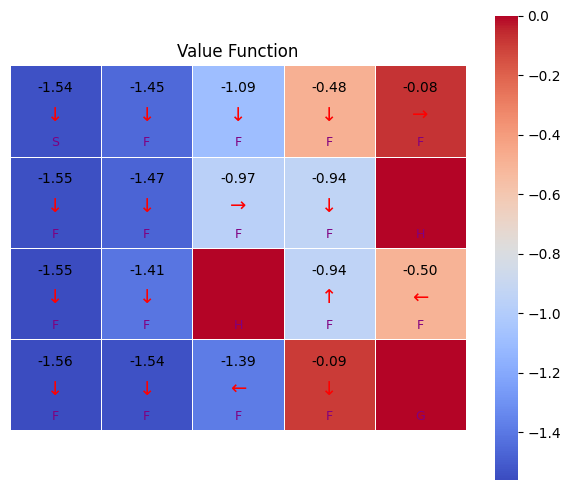

In [492]:
plot_value_function(env,V_fisrt_carlo,policy_V)

-----------

-----------

# ${\color{pink}\mathbb{Monte-Carlo-GLIE}}$

For each state $S_t$ and action $A_t$ in the episode:

$$  N(S_t, A_t) = N(S_t, A_t) + 1   $$

$$ Q(S_t, A_t) =  Q(S_t, A_t) + \frac{1}{N(S_t, A_t)} \cdot (G_t - Q(S_t, A_t))$$

we will use $\alpha$ const. : 



$$ Q(S_t, A_t) =  Q(S_t, A_t) + \alpha \cdot (G_t - Q(S_t, A_t))$$

$$  G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{T - t - 1} R_T    $$


In [ ]:
def get_q(epis,t,my_q,alpha):     #Q(S_t , A_T)


    s, a, _ = epis[t]
    G_t = get_g(epis,t)
    
    my_q[s][a] = my_q[s][a] + alpha*(G_t-my_q[s][a])

    return my_q

-----

### ${\color{pink}\mathbb{Implementation}}$

In [288]:
def epsilon_greedy_policy(state, Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])  #greedy


In [497]:
def monte_carlo_glie(env,alpha,epsilon=0.0001,max_iter=200):

    n_states = env.observation_space.n    
    n_actions = env.action_space.n
    
    my_q = np.zeros((n_states,n_actions))    

    policy = np.random.choice(range(n_actions), size=n_states)
 

    for i in range(max_iter):

        visited_sa = set()
        
        episode = generate_episode(env,policy)

        for t in range(len(episode)):

            s, a, _ = episode[t]

            if (s, a) not in visited_sa:    #first visit....
                visited_sa.add((s, a))
                my_q = get_q(episode, t, my_q, alpha)  

        
        for state,_ in visited_sa:  #only change where i visited...
            policy[state] = epsilon_greedy_policy(state, my_q, epsilon)
        
    #final_policyy = np.argmax(my_q,axis=1)

    return policy,my_q



In [495]:
env = gym.make("CustomFrozenLake-v0", is_slippery=True, slip_prob=0.2)
P = env.unwrapped.P
print(P)

policy, Q = monte_carlo_glie(env, alpha=0.01, epsilon=0.0001, max_iter=30000)
print(policy)

{0: {0: [(0.1, 0, -0.08, False), (0.8, 0, -0.08, False), (0.1, 5, -0.08, False)], 1: [(0.1, 0, -0.08, False), (0.8, 5, -0.08, False), (0.1, 1, -0.08, False)], 2: [(0.1, 5, -0.08, False), (0.8, 1, -0.08, False), (0.1, 0, -0.08, False)], 3: [(0.1, 1, -0.08, False), (0.8, 0, -0.08, False), (0.1, 0, -0.08, False)]}, 1: {0: [(0.1, 1, -0.08, False), (0.8, 0, -0.08, False), (0.1, 6, -0.08, False)], 1: [(0.1, 0, -0.08, False), (0.8, 6, -0.08, False), (0.1, 2, -0.08, False)], 2: [(0.1, 6, -0.08, False), (0.8, 2, -0.08, False), (0.1, 1, -0.08, False)], 3: [(0.1, 2, -0.08, False), (0.8, 1, -0.08, False), (0.1, 0, -0.08, False)]}, 2: {0: [(0.1, 2, -0.08, False), (0.8, 1, -0.08, False), (0.1, 7, -0.08, False)], 1: [(0.1, 1, -0.08, False), (0.8, 7, -0.08, False), (0.1, 3, -0.08, False)], 2: [(0.1, 7, -0.08, False), (0.8, 3, -0.08, False), (0.1, 2, -0.08, False)], 3: [(0.1, 3, -0.08, False), (0.8, 2, -0.08, False), (0.1, 1, -0.08, False)]}, 3: {0: [(0.1, 3, -0.08, False), (0.8, 2, -0.08, False), (0.1

In [369]:
#Q

----

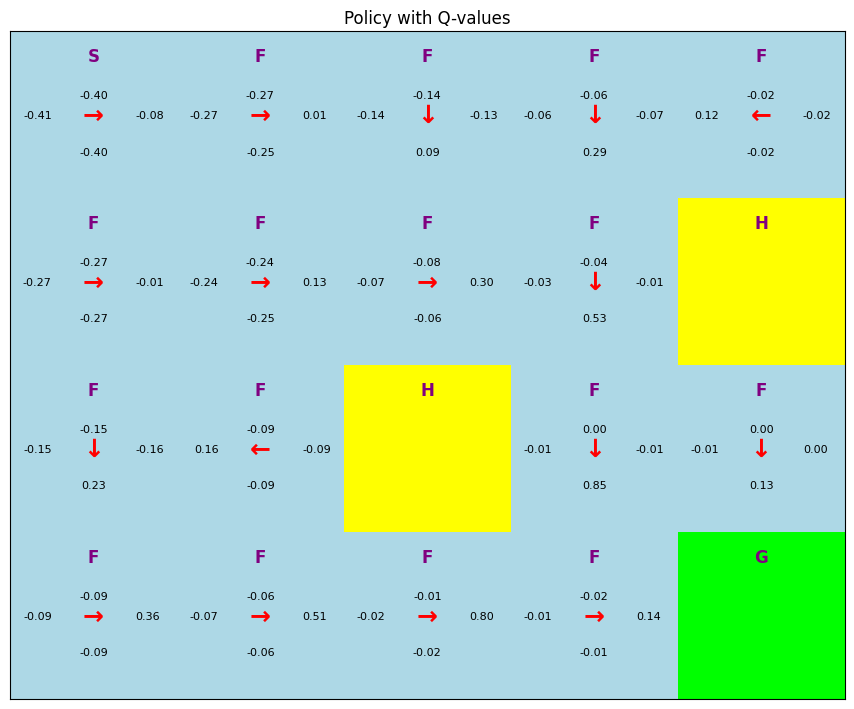

In [367]:
plot_policy(env,policy,Q)

not the best....

the values aren't that good and the policy itself could be a bit better but it gets to the GOAL



In [295]:
env.close()

----

----

# ${\color{pink}\mathbb{Experiment}}$

A tiny experiment to see what alphas and max_iter could be better (just to see visually)

In [485]:
env = gym.make("CustomFrozenLake-v0", is_slippery=True, slip_prob=0.2)
P = env.unwrapped.P
print(P[0])


print("----starting----")
policy1, Q1 = monte_carlo_glie(env, alpha=0.01, epsilon=0.0001, max_iter=30000)
print("----finished 1----")
policy2, Q2 = monte_carlo_glie(env, alpha=0.1, epsilon=0.0001, max_iter=30000)
print("----finished 2----")
policy3, Q3 = monte_carlo_glie(env, alpha=0.7, epsilon=0.0001, max_iter=30000)
print("----finished 3----")
policy4, Q4 = monte_carlo_glie(env, alpha=0.01, epsilon=0.0001, max_iter=7000)
print("----finished 4----")
policy5, Q5 = monte_carlo_glie(env, alpha=0.7, epsilon=0.0001, max_iter=700)
print("----finished 5----")
policy6, Q6 = monte_carlo_glie(env, alpha=0.01, epsilon=0.0001, max_iter=700)
print("----finished 6----")
policy7, Q7 = monte_carlo_glie(env, alpha=0.2, epsilon=0.0001, max_iter=1000)
print("----finished 7----")
policy8, Q8 = monte_carlo_glie(env, alpha=0.2, epsilon=0.0001, max_iter=100)
print("----finished 8----")



{0: [(0.1, 0, -0.08, False), (0.8, 0, -0.08, False), (0.1, 5, -0.08, False)], 1: [(0.1, 0, -0.08, False), (0.8, 5, -0.08, False), (0.1, 1, -0.08, False)], 2: [(0.1, 5, -0.08, False), (0.8, 1, -0.08, False), (0.1, 0, -0.08, False)], 3: [(0.1, 1, -0.08, False), (0.8, 0, -0.08, False), (0.1, 0, -0.08, False)]}
----starting----
----finished 1----
----finished 2----
----finished 3----
----finished 4----
----finished 5----
----finished 6----
----finished 7----
----finished 8----


normal 0.01 alpha


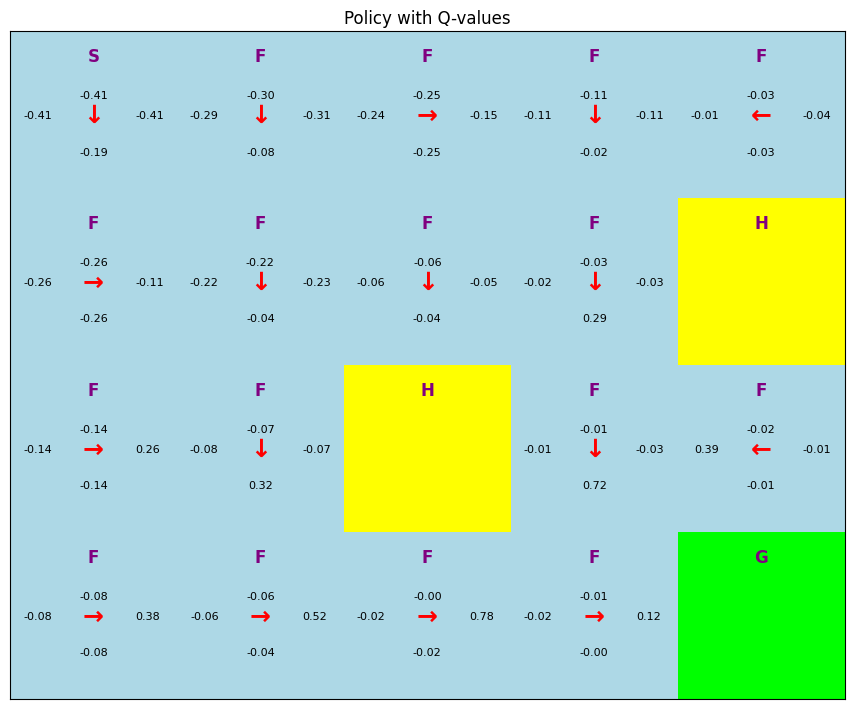

0.1 alpha


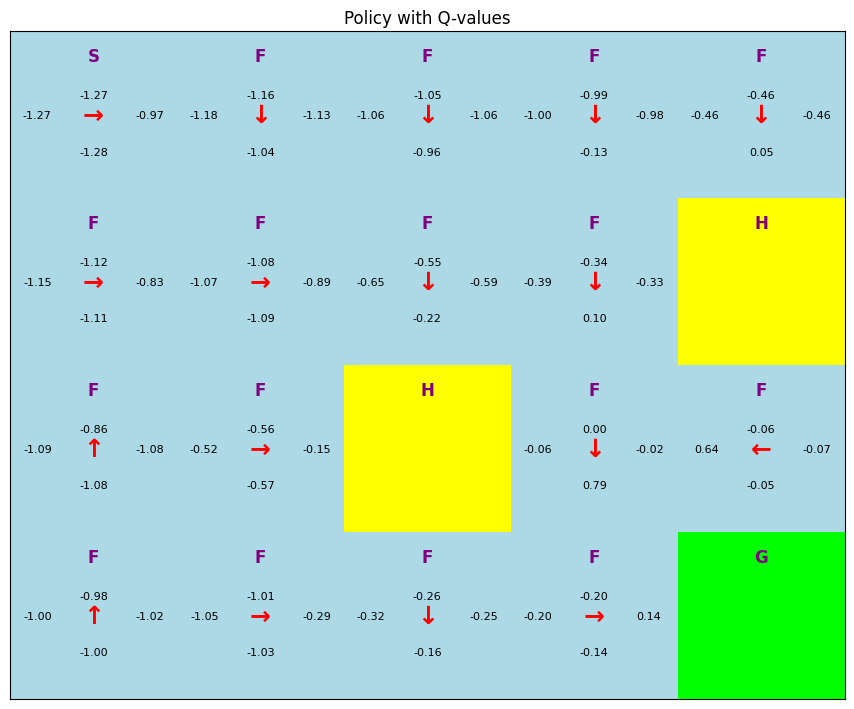

high alpha 0.7


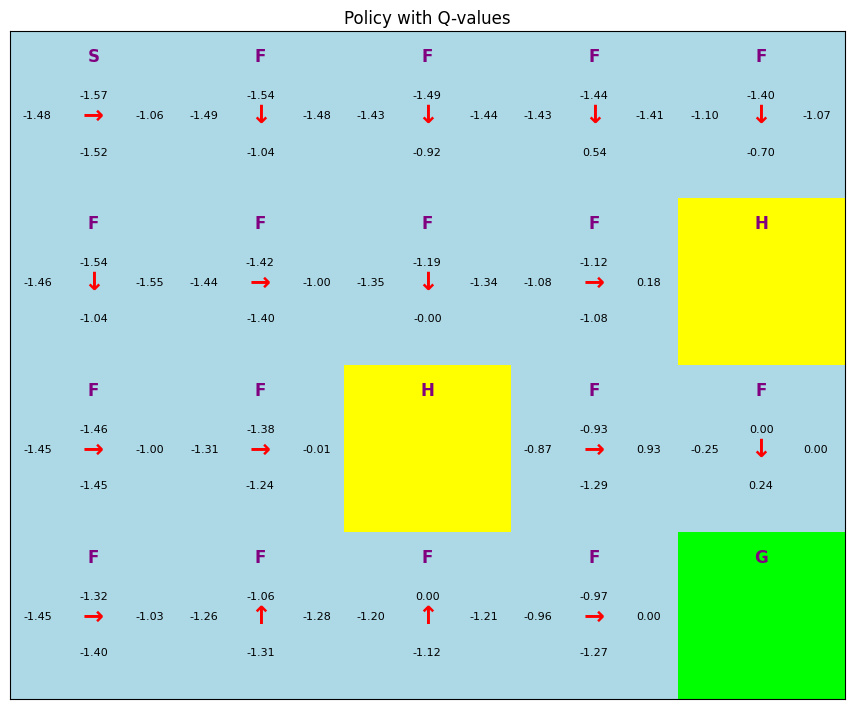

max_iter half low (7000)


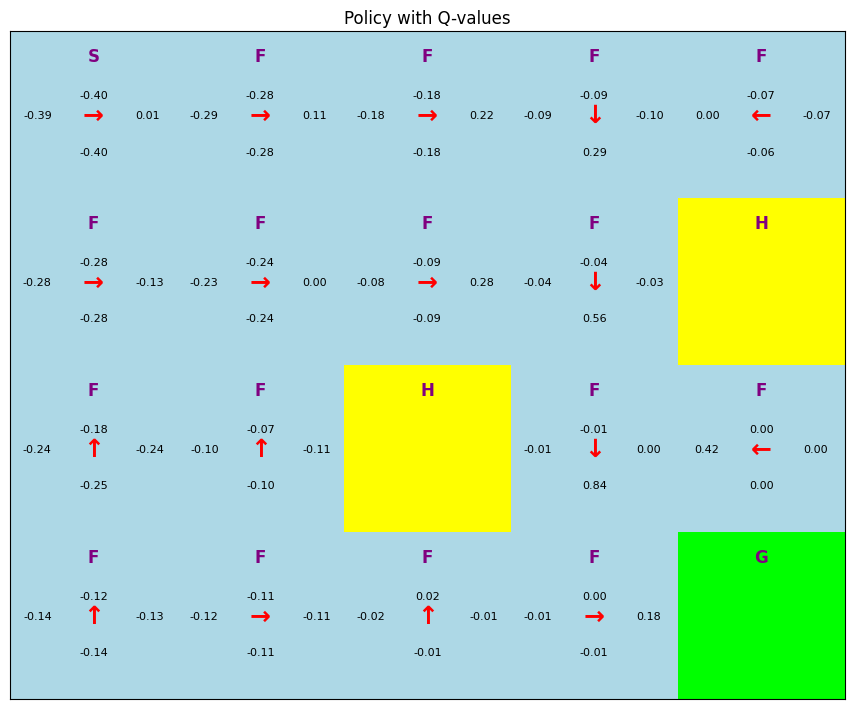

high alpha(0.7), low max_iter(700)


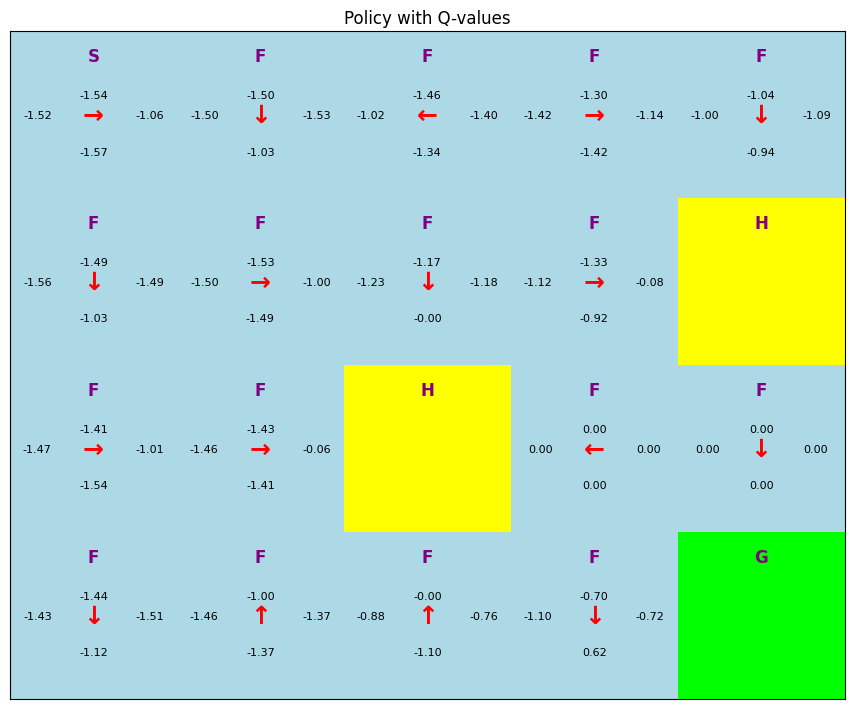

low alpha(0.01), low max_iter(700)


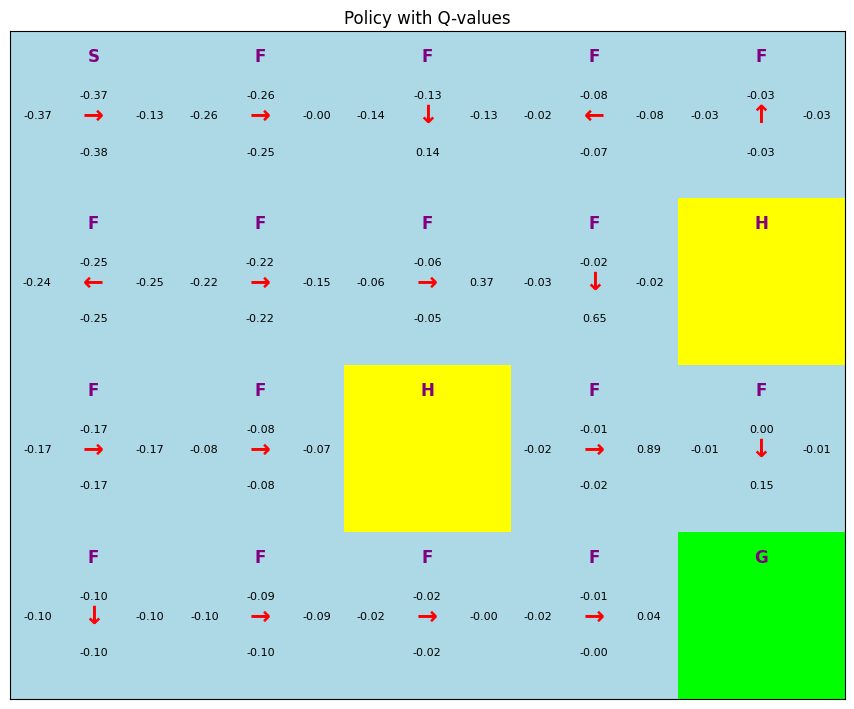

low alpha(0.2), low max_iter(1000)


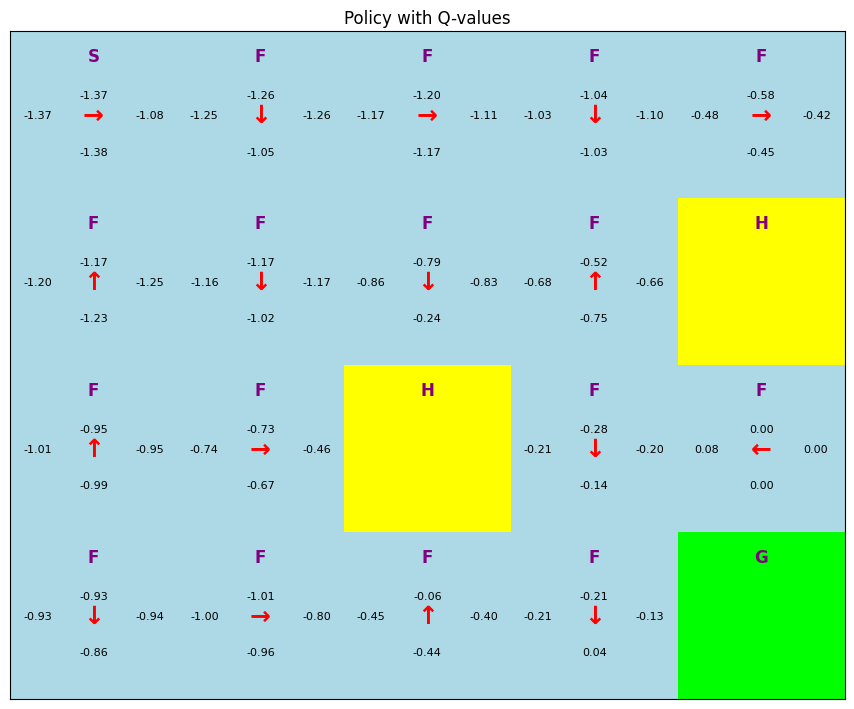

low alpha(0.2), low max_iter(100)


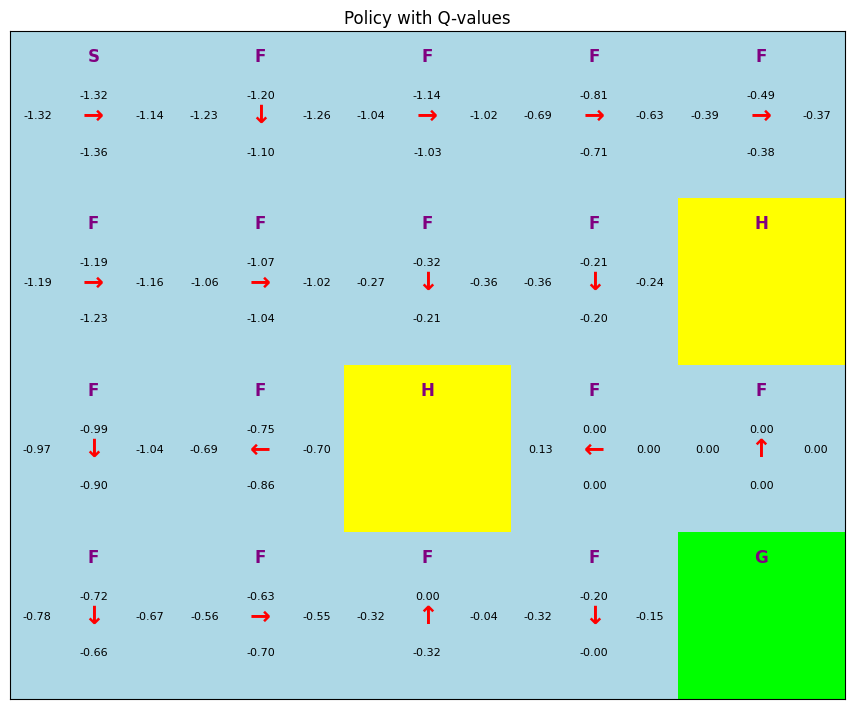

In [486]:
print("normal 0.01 alpha")
plot_policy(env,policy1,Q1)
print("0.1 alpha")
plot_policy(env,policy2,Q2)
print("high alpha 0.7")
plot_policy(env,policy3,Q3)
print("max_iter half low (7000)")
plot_policy(env,policy4,Q4)
print("high alpha(0.7), low max_iter(700)")
plot_policy(env,policy5,Q5)
print("low alpha(0.01), low max_iter(700)")
plot_policy(env,policy6,Q6)
print("low alpha(0.2), low max_iter(1000)")
plot_policy(env,policy7,Q7)
print("low alpha(0.2), low max_iter(100)")
plot_policy(env,policy8,Q8)


### ${\color{pink}\mathbb{Conclusions-From-This-Experiment:}}$

(alpha - learning rate..)

-lower alpha is better,

-it looks like the alpha is affecting more then the max_iter

-Still I had to do a lot of iter to get to a good policy

-Still more iter is better... 

---------------------------

------

-----------

-----------

-----------

-----------

### ${\color{orange}\mathbb{Notes}}$

The plotting code was made by ChatGPT 

The Monte_Carlo_First (Using V) doesn't seem to work well.

I didn't finish in time :\